In [8]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from shared.training import train_classifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import shared.utils as utils

torch.manual_seed(42)

datasets = {}
loaders = {}

images = torch.load("03_baseline_cnn/data/extracted_features/basedata.pt")
labels = torch.load("03_baseline_cnn/data/extracted_features/basedata_labels.pt")

thresholds = [0.5, 0.67, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1-1e-14]

(1000, 960)


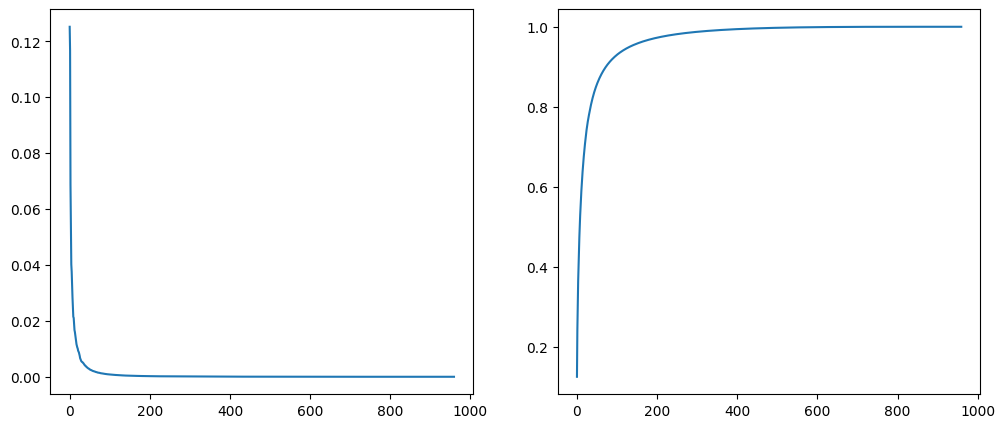

In [9]:
pca = PCA()
pca_features = pca.fit_transform(images)
cumsum = torch.cumsum(torch.tensor(pca.explained_variance_ratio_).squeeze(), dim=0)

print(pca_features.shape)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].plot(pca.explained_variance_ratio_)
ax[1].plot(cumsum)

In [10]:
for threshold in thresholds:
    n_components = (cumsum < threshold).sum().item() + 1  # +1 to include the component that reaches the threshold
    print(f"Number of components for {threshold*100}% explained variance: {n_components}")

Number of components for 50.0% explained variance: 8
Number of components for 67.0% explained variance: 18
Number of components for 75.0% explained variance: 27
Number of components for 80.0% explained variance: 35
Number of components for 85.0% explained variance: 49
Number of components for 90.0% explained variance: 74
Number of components for 95.0% explained variance: 133
Number of components for 99.0% explained variance: 332
Number of components for 99.999999999999% explained variance: 838


## For all samples

In [11]:
# def reduce_reconstruct(images, N=None, threshold=None):
#     assert any([N is not None, threshold is not None]), "Either N or threshold must be specified."
#     assert not all([N is not None, threshold is not None]), "Only one of N or threshold can be specified."
    
#     pca = PCA()

#     if threshold is not None:
#         N = (cumsum < threshold).sum().item() + 1

#     transformed = pca.fit_transform(images) # (1000, 960) -> (1000, 960)
#     transformed = torch.tensor(transformed)[:, :N] # (1000, 960) -> (1000, N)
#     components = torch.tensor(pca.components_[:N, :])  # (N, 960)
    
#     mean = torch.tensor(pca.mean_).repeat((1000,1))# (960, 1000)

#     reconstructed = transformed @ components + mean  # (960, N) @ (N, 1000) + (960, 1000)

#     return reconstructed

# for thr in thresholds:
#     reconstructed = reduce_reconstruct(images, threshold=thr)
#     print(images[0, :8])
#     print(reconstructed[0, :8])

In [12]:
def get_model_inputs_from_batch(batch):
    return [batch[0]]
def get_labels_from_batch(batch):
    return batch[1]

Processing dataset with threshold 0.5 and shape torch.Size([1000, 8])
Processing dataset with threshold 0.67 and shape torch.Size([1000, 18])
Processing dataset with threshold 0.75 and shape torch.Size([1000, 27])
Processing dataset with threshold 0.8 and shape torch.Size([1000, 35])
Processing dataset with threshold 0.85 and shape torch.Size([1000, 49])
Processing dataset with threshold 0.9 and shape torch.Size([1000, 74])
Processing dataset with threshold 0.95 and shape torch.Size([1000, 133])
Processing dataset with threshold 0.99 and shape torch.Size([1000, 332])
Processing dataset with threshold 0.99999999999999 and shape torch.Size([1000, 838])


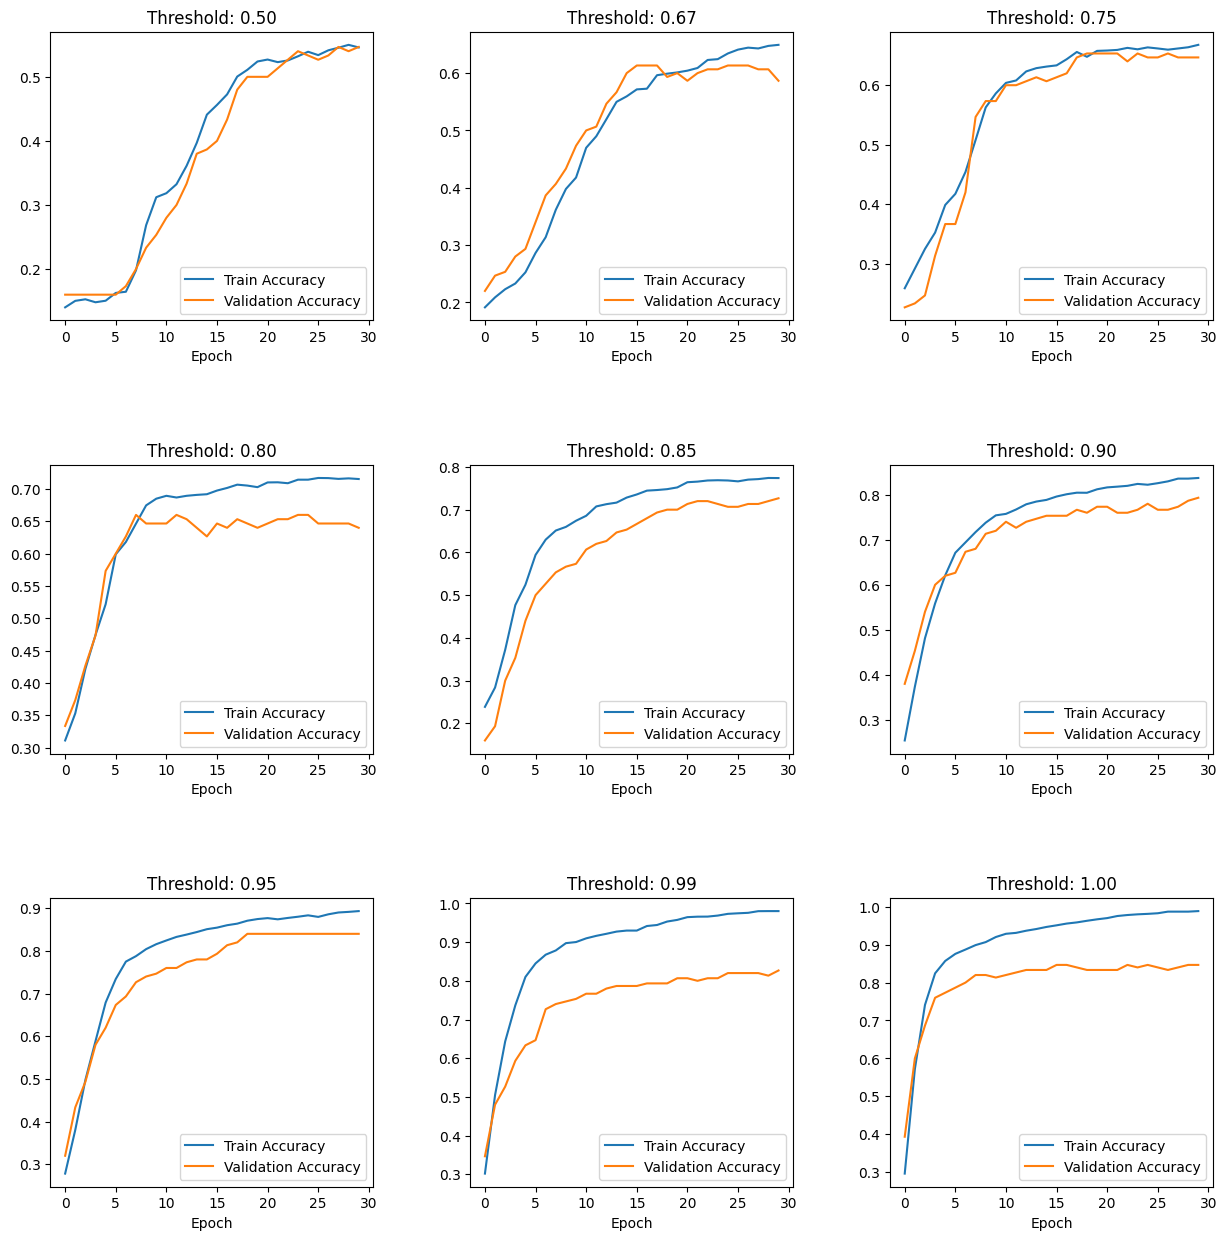

In [15]:
fig, axs = plt.subplots(*utils.closest_factors(len(thresholds)), figsize=(15,15),gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
axs = axs.flatten() if len(thresholds) > 1 else [axs]


for idx, thr in enumerate(thresholds):
    dataset = torch.utils.data.TensorDataset(torch.tensor(PCA(thr).fit_transform(images), dtype=torch.float), labels)
    print(f"Processing dataset with threshold {thr} and shape {dataset.tensors[0].shape}")

    datasets = {}
    loaders = {}

    for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
        datasets[split] = dataset
        loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))


    model = nn.Sequential(
        nn.Linear(datasets["train"][0][0].shape[0], len(torch.unique(labels))),
    )
    model.get_model_inputs_from_batch = get_model_inputs_from_batch
    model.get_labels_from_batch = get_labels_from_batch

    
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate

    train_accs, val_accs = train_classifier(
        N_epochs=30,
        model=model,
        train_dataloader=loaders["train"],
        val_dataloader=loaders["val"],
        optimizer=optimizer,
        loss=loss,
        output_loc=None,
    )

    ax = axs[idx]
    ax.plot(train_accs, label='Train Accuracy')
    ax.plot(val_accs, label='Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.set_title(f"Threshold: {thr:.2f}")

# Trying with deeper model with dropout

Processing dataset with threshold 0.5 and shape torch.Size([1000, 8])
Processing dataset with threshold 0.67 and shape torch.Size([1000, 18])
Processing dataset with threshold 0.75 and shape torch.Size([1000, 27])
Processing dataset with threshold 0.8 and shape torch.Size([1000, 35])
Processing dataset with threshold 0.85 and shape torch.Size([1000, 49])
Processing dataset with threshold 0.9 and shape torch.Size([1000, 74])
Processing dataset with threshold 0.95 and shape torch.Size([1000, 133])
Processing dataset with threshold 0.99 and shape torch.Size([1000, 332])
Processing dataset with threshold 0.99999999999999 and shape torch.Size([1000, 838])


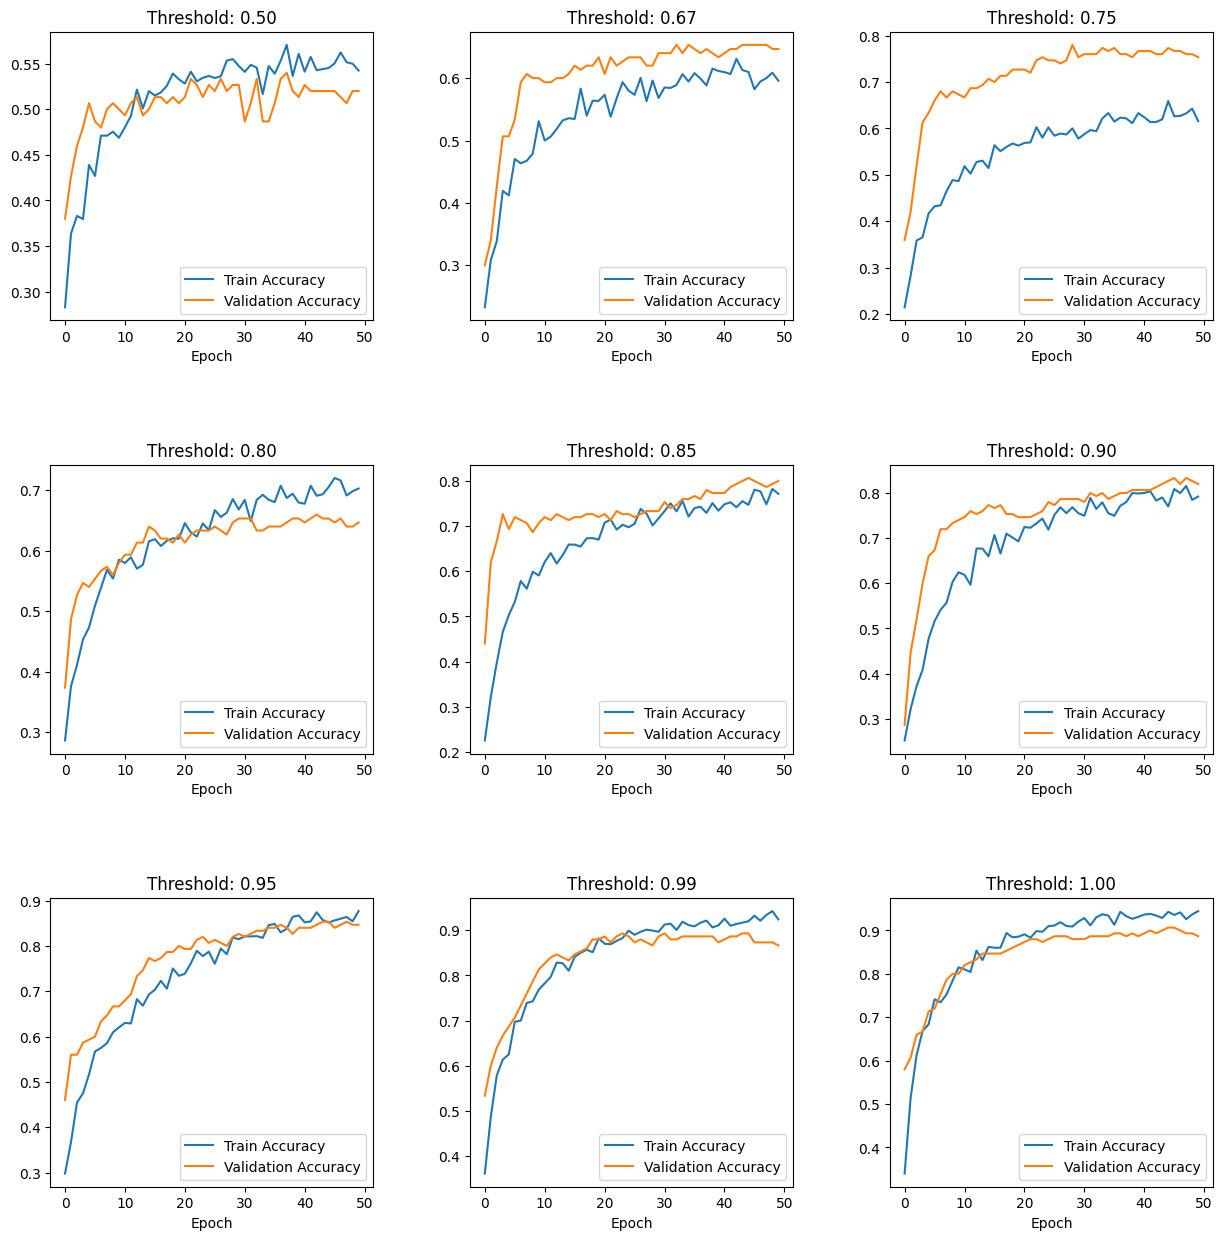

In [20]:
fig, axs = plt.subplots(*utils.closest_factors(len(thresholds)), figsize=(15,15),gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
axs = axs.flatten() if len(thresholds) > 1 else [axs]


for idx, thr in enumerate(thresholds):
    dataset = torch.utils.data.TensorDataset(torch.tensor(PCA(thr).fit_transform(images), dtype=torch.float), labels)
    print(f"Processing dataset with threshold {thr} and shape {dataset.tensors[0].shape}")

    datasets = {}
    loaders = {}

    for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
        datasets[split] = dataset
        loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))


    model = nn.Sequential(
        nn.Linear(datasets["train"][0][0].shape[0],32), 
        nn.Dropout(0.7), 
        nn.ReLU(),
        nn.Linear(32, len(torch.unique(labels))),
    )
    model.get_model_inputs_from_batch = get_model_inputs_from_batch
    model.get_labels_from_batch = get_labels_from_batch

    
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate

    train_accs, val_accs = train_classifier(
        N_epochs=50,
        model=model,
        train_dataloader=loaders["train"],
        val_dataloader=loaders["val"],
        optimizer=optimizer,
        loss=loss,
        output_loc=None,
    )

    ax = axs[idx]
    ax.plot(train_accs, label='Train Accuracy')
    ax.plot(val_accs, label='Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.set_title(f"Threshold: {thr:.2f}")